In [4]:
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np
import torch

from hoechstgan.data import create_dataset
from hoechstgan.util import tensor2im

from test import load_run_cfg, setup_model

GlobalHydra().clear()
cfg = load_run_cfg("jkg2ys89")
initialize(config_path="conf", version_base="1.2")
test_cfg = compose("test_overrides.yaml", overrides=["dataset.batch_size=1"])
cfg = OmegaConf.merge(cfg, test_cfg)

dataset = create_dataset(cfg)

data = next(iter(dataset))

Reusing existing split...
48800 samples were split into train=43920, val=0, test=4880.


In [15]:
model = setup_model(cfg)
model.set_input(data)

Checkpoints directory: /data/checkpoints/jkg2ys89
Dry run of generator:
  Encoding real_A -> latent_A
  Decoding latent_A -> fake_B
  Encoding fake_B -> latent_B
  Decoding latent_A,latent_B -> fake_C
  Done, generated following outputs: real_A, fake_B, fake_C
initialize network with normal
Loading network from epoch: latest
Loading module from /data/checkpoints/jkg2ys89/latest_net_G.pth
---------- Networks initialized -------------
DataParallel(
  (module): UnetGenerator(
    (encoders): PairedSerializedModuleDict(
      ('real_A'=>'latent_A'): UnetEncoder(
        (0): UnetDown(
          (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        )
        (1): UnetDown(
          (0): LeakyReLU(negative_slope=0.2)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): UnetDown(
          (0): Leak

In [29]:
torch.no_grad().__enter__()

def substitute(latent):
    return [torch.zeros_like(x) for x in latent]
    return [torch.normal(0., 1., x.shape).to(model.device) for x in latent]

fake_B, fake_C = model.netG(model.real_A, verbose=True)
fake_B_sub, fake_C_sub = model.netG(model.real_A, verbose=True, latent_substitutions={"latent_B": substitute})

Dry run of generator:
  Encoding real_A -> latent_A
  Decoding latent_A -> fake_B
  Encoding fake_B -> latent_B
  Decoding latent_A,latent_B -> fake_C
  Done, generated following outputs: real_A, fake_B, fake_C
Dry run of generator:
  Encoding real_A -> latent_A
  Decoding latent_A -> fake_B
  Encoding fake_B -> latent_B
  Substituting latent code for latent_B
  Decoding latent_A,latent_B -> fake_C
  Done, generated following outputs: real_A, fake_B, fake_C


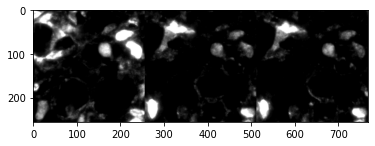

In [30]:
plt.imshow(tensor2im(torch.cat((model.real_B, fake_B, fake_B_sub), axis=-1)), cmap="gray")

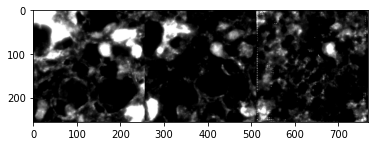

In [31]:
plt.imshow(tensor2im(torch.cat((model.real_C, fake_C, fake_C_sub), axis=-1)), cmap="gray")